# Import all kind of stuff

In [20]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.markers import MarkerStyle
from matplotlib.lines import Line2D

import superconductivity.api as sc

from superconductivity.api import G_0_muS
from superconductivity.api import NDArray64

from IPython import get_ipython

_ip = get_ipython()
if _ip is not None:
    _ip.run_line_magic("reload_ext", "autoreload")
    _ip.run_line_magic("autoreload", "2")

    _ip.run_line_magic(
        "config",
        "InlineBackend.print_figure_kwargs = {'bbox_inches': None, 'pad_inches': 0.0}",
    )
    _ip.run_line_magic("config", 'InlineBackend.figure_format = "retina"')  # or "png"
    _ip.run_line_magic(
        "config", "InlineBackend.rc = {'figure.dpi': 300}"
    )  # choose a value you like

# RCSJ IV

\begin{align}
I_{\rm bias}(t) &= I_{SC}(\phi(t)) + I_{\rm QP}(V(t)) + C\,\dot V(t) + I_n(t, V(t))\\
I_{SC}(\phi(t)) &= I_c\sin\varphi(t) \\
I_n(t, V(t)) &= I_{\rm th}(t, V(t)) + I_{\rm add}(t)\\
I_{\rm th}(t, V(t))&=\sqrt{4k_B T_{\rm eff}\,G_d(V(t))}\;\xi_1(t)\\
I_{\rm add}(t)&=\sqrt{S_{\rm add}}\;\xi_2(t)\\
\langle \xi_i(t)\xi_i(t')\rangle&=\delta(t-t')\\
V(t)&=\dfrac{\Phi_0}{2\pi}\dot\varphi(t)\\
\Rightarrow \dot V &= \frac{1}{C}\Big[I_{\rm bias}(t)-I_c\sin\varphi - I_{\rm QP}(V) - I_{\rm th} - I_{\rm add}\Big].
\end{align}
Discretize with Euler–Maruyama (time step $dt$). Replace $\xi(t)$ by $\eta/\sqrt{dt}$, $\eta\sim\mathcal N(0,1)$. Then the stochastic current kicks per step are:
\begin{align}
I_{\rm th,k}&=\sqrt{\frac{4k_BT_{\rm eff}\,G_d(V_k)}{dt}}\eta_{1,k},\\
I_{\rm add,k}&=\sqrt{\frac{S_{\rm add}}{dt}}\eta_{2,k}.
\end{align}

In [97]:
# definitions

V_bias = np.linspace(-4.5, 4.5, 1501)
I_bias = np.linspace(-4.5, 4.5, 101)
A_bias = np.linspace(0, 4, 101)

G_N = 1.0
Delta_meV = 0.180
T_K = 0.0
gamma_meV = 1e-3
nu_GHz = 10.0
C_pF = 1

I_c = sc.get_Ic_ab(Delta_meV=Delta_meV, G_N=G_N, T_K=T_K)
I_c_nA = sc.get_Ic_ab_nA(Delta_meV=Delta_meV, G_N=G_N, T_K=T_K)

V_bias_mV = V_bias * Delta_meV
A_bias_mV = A_bias * Delta_meV
I_bias_nA = I_bias * G_N * Delta_meV * G_0_muS

# region I_bcs, V_bcs, V_qp
I_bcs_nA = sc.get_I_bcs_nA(
    V_mV=V_bias_mV,
    G_N=G_N,
    T_K=T_K,
    Delta_meV=Delta_meV,
    gamma_meV=gamma_meV,
)
I_bcs = I_bcs_nA / (G_0_muS * Delta_meV)
dIdV_bcs = np.gradient(I_bcs, V_bias)
dIdV_bcs_muS = np.gradient(I_bcs_nA, V_bias_mV)


dIdV_iqp_muS_sqrt = sc.jnp_interp_y_of_x(x=V_bias_mV, y=np.sqrt(dIdV_bcs_muS), dydx=0.0)
I_iqp_nA = sc.jnp_interp_y_of_x(x=V_bias_mV, y=I_bcs_nA, dydx=G_N * G_0_muS)
# endregion

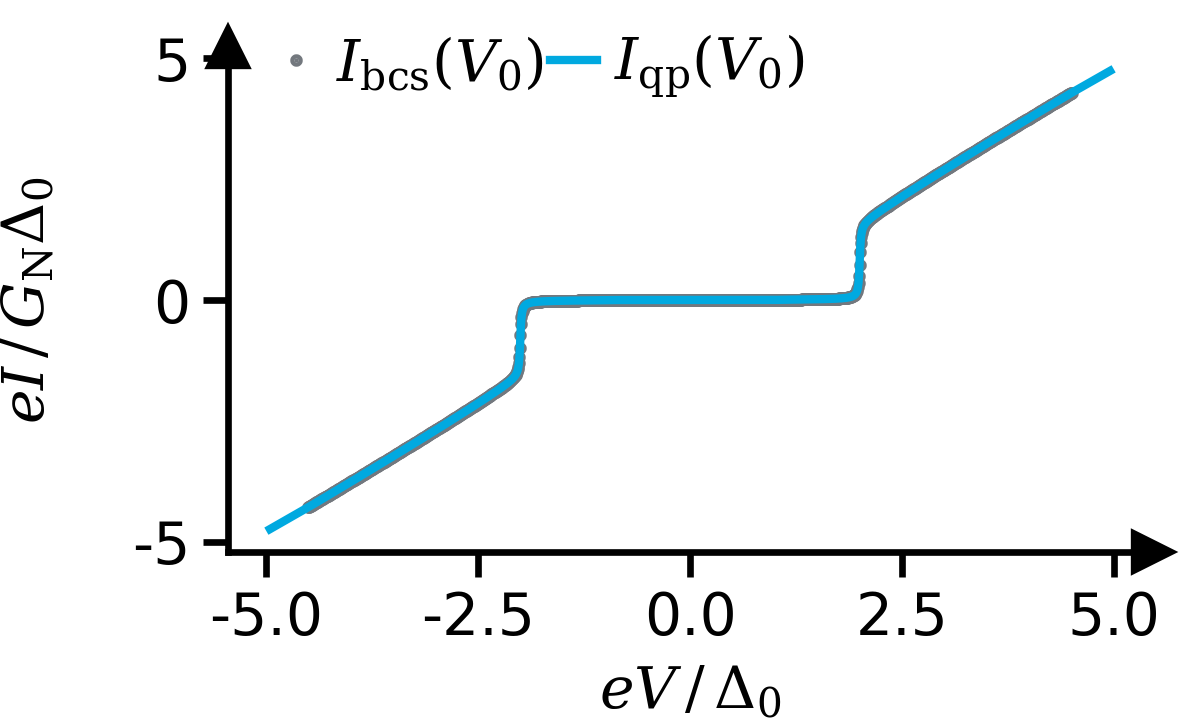

In [98]:
figsize = (2.0, 1.2)
fig, ax = sc.get_figure(figsize=figsize, padding=(0.3, 0.2))

ax.plot(
    V_bias,
    I_bcs,
    ".",
    color=sc.seegrau100,
    label="$I_\\mathrm{bcs}(V_0)$",
)
ax.plot(
    V_bias * 1.1,
    I_iqp_nA(V_bias_mV * 1.1) / (G_0_muS * Delta_meV),
    color=sc.seeblau100,
    label="$I_\\mathrm{qp}(V_0)$",
)

ax.legend(
    handlelength=0.8,
    loc="upper left",
    frameon=False,
    fontsize=7,
    title_fontsize=7,
    ncols=2,
    columnspacing=0.1,
    borderpad=0.1,  # reduces padding inside the legend box
    labelspacing=0.3,  # reduces vertical spacing between items
    handletextpad=0.3,  # reduces spacing between line and label
    bbox_to_anchor=(0.01, 1.1),
)

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$eI\\,/\\,G_\\mathrm{N}\\Delta_0$"
title = None

sc.theory_layout(fig, ax, title, xlabel, ylabel)

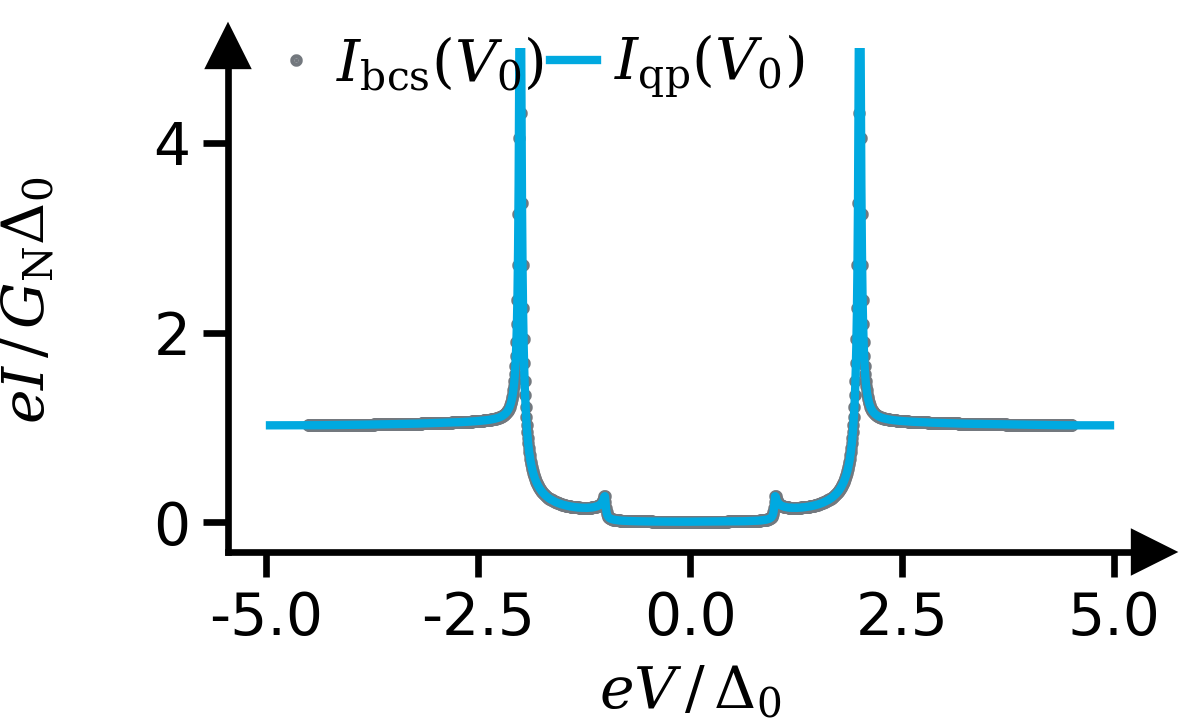

In [101]:
figsize = (2.0, 1.2)
fig, ax = sc.get_figure(figsize=figsize, padding=(0.3, 0.2))

ax.plot(
    V_bias,
    np.sqrt(dIdV_bcs),
    ".",
    color=sc.seegrau100,
    label="$I_\\mathrm{bcs}(V_0)$",
)
ax.plot(
    V_bias * 1.1,
    dIdV_iqp_muS_sqrt(V_bias_mV * 1.1) / np.sqrt(G_0_muS),
    color=sc.seeblau100,
    label="$I_\\mathrm{qp}(V_0)$",
)

ax.legend(
    handlelength=0.8,
    loc="upper left",
    frameon=False,
    fontsize=7,
    title_fontsize=7,
    ncols=2,
    columnspacing=0.1,
    borderpad=0.1,  # reduces padding inside the legend box
    labelspacing=0.3,  # reduces vertical spacing between items
    handletextpad=0.3,  # reduces spacing between line and label
    bbox_to_anchor=(0.01, 1.1),
)
ax.set_ylim(None, 5)

xlabel = "$eV\\,/\\,\\Delta_0$"
ylabel = "$eI\\,/\\,G_\\mathrm{N}\\Delta_0$"
title = None

sc.theory_layout(fig, ax, title, xlabel, ylabel)

A consistent minimal model is:

(1) Current balance (unchanged, still current-biased)

$C\,\dot V(t)= I_{\rm dc}\;-\;I_c\sin\phi(t)\;-\;I_{\rm qp}(V(t))\;+\;I_{\rm th}(t,V(t)).$

Here V(t) is the dynamical junction voltage coming out of the circuit equation.

(2) Josephson relation with an added AC voltage source

$\dot\phi(t)=\frac{2e}{\hbar}\Big(V(t) + V_{\rm ac}\sin\omega t\Big).$

(3) Thermal noise (discrete time)
If you use a dimensionless Gaussian $\eta_k\sim\mathcal N(0,1)$,

$I_{{\rm th},k}= \sqrt{\frac{4k_B T_{\rm eff}\,G_d(V_k)}{\Delta t}}\;\eta_k,$

with $G_d(V)=\mathrm d I_{\rm qp}/\mathrm dV$ (plus any explicit extra shunt conductance if you include one).

Discrete update (Euler-Maruyama) for timestep $\Delta t$:

- compute deterministic current imbalance
$I_{\rm det}=I_{\rm dc}-I_c\sin\phi_k-I_{\rm qp}(V_k),$

- draw noise $I_{{\rm th},k},$

- update voltage
$V_{k+1}=V_k+\frac{\Delta t}{C}\big(I_{\rm det}+I_{{\rm th},k}\big),$

- update phase with AC term
$\phi_{k+1}=\phi_k+\Delta t\,\frac{2e}{\hbar}\Big(V_k+V_{\rm ac}\sin(\omega t_k)\Big).$

In [ ]:
import jax
from typing import Sequence
import jax.numpy as jnp


def get_V_rcsj_mV(
    I_bias_nA: NDArray64,  # (NI,)
    A_bias_mV: NDArray64,  # (NA,)
    V_bias_mV: NDArray64,  # (NV,)
    I_qp_nA: NDArray64,  # (NA, NV)
    I_sc_nA: float | Sequence[float] = 1.0,
    C_pF: float = 1e-4,
    Delta_meV: float = 0.18,
    T_K: float = 0.0,
    nu_GHz: float = 10.0,
    dt_ns: float = 1e-3,
    t_steps: int = 2_000,
    burn_frac: float = 0.5,
    seed: int = 0,
) -> NDArray64:  # (NA, NI)

    dIdV_qp_muS = np.gradient(I_qp_nA, V_bias_mV, axis=1)  # (NA, NV)
    V_rcsj_mV = np.zeros((A_bias_mV.shape[0], I_bias_nA.shape[0]))  # (NA, NI)

    @jax.jit
    def get_I_qp_nA(
        v_bias_mV: float,
        i_a: int,
    ) -> float:
        i_qp_nA = 0.0
        v_bias_mV = jnp.clip(v_bias_mV, V_bias_mV[0], V_bias_mV[-1])

        # i such that x[i] <= xq < x[i+1]
        i_v = jnp.searchsorted(v_bias_mV, V_bias_mV, side="right") - 1
        i_v = jnp.clip(i_v, 0, V_bias_mV.size - 2)

        v_bias_0 = V_bias_mV[i_v]
        v_bias_1 = V_bias_mV[i_v + 1]
        i_qp_0 = I_qp_nA[i_a, i_v]
        i_qp_1 = I_qp_nA[i_a, i_v + 1]

        w = (v_bias_mV - v_bias_0) / (v_bias_1 - v_bias_0)
        i_qp_nA = i_qp_0 + w * (i_qp_1 - i_qp_0)

        return i_qp_nA

    @jax.jit
    def get_dG_muS(
        v_bias_mV: float,
        a_bias_mA: float,
    ) -> float:
        dg_qp_nA = 0.0
        # do some argsort stuff on dIdV_qp_muS
        return dg_qp_nA

    @jax.jit
    def get_i_sc_nA(
        phi_mV_ns: float,
    ) -> float:
        i_sc_nA = 0.0
        # do the sine, expand it for a sequence of I_sc_nA
        return i_sc_nA

    @jax.jit
    def get_i_th_nA(
        v_bias_mV: float,
        a_bias_mA: float,
    ) -> float:
        i_th_nA = 0.0
        # call get_dG_muS and do shenanigans

    @jax.jit
    def get_v_rcsj_mV(
        i_bias_nA: float,
        a_bias_mV: float,
    ) -> float:
        v_rcsj_mV = 0.0
        # do the heavy load..
        return v_rcsj_mV

    # call get_v_rcsj_mV with vmap()

    return V_rcsj_mV

In [ ]:
I_bias = np.linspace(-4.5, 4.5, 101)
A_bias = np.linspace(0, 4, 101)
V_bias = np.linspace(-6, 6, 3001)

G_N = 1.0
T_K = 0.0
Delta_meV = 0.180
gamma_meV = 1e-3
nu_GHz = 10.0
C_pF = 1

I_bias_nA = I_bias * G_N * Delta_meV * G_0_muS
V_bias_mV = V_bias * Delta_meV
A_bias_mV = A_bias * Delta_meV

# qp current
I_bcs_nA = sc.get_I_bcs_nA(
    V_mV=V_bias_mV,
    G_N=G_N,
    T_K=T_K,
    Delta_meV=Delta_meV,
    gamma_meV=gamma_meV,
)
I_pat_nA = sc.get_I_pat_nA(
    V_mV=V_bias_mV,
    I_nA=I_bcs_nA,
    A_mV=A_bias_mV,
    nu_GHz=nu_GHz,
    n_max=100,
    m=1,
)
I_qp_nA = I_pat_nA

# sc current
I_c_nA = sc.get_Ic_ab_nA(Delta_meV=Delta_meV, G_N=G_N, T_K=T_K)
I_sc_nA = I_c_nA

# rcsj voltage
V_rcsj_mV = get_V_rcsj_mV(
    I_bias_nA=I_bias_nA,
    A_bias_mV=A_bias_mV,
    V_bias_mV=V_bias_mV,
    I_qp_nA=I_qp_nA,
    I_sc_nA=I_sc_nA,
    C_pF=C_pF,
    Delta_meV=Delta_meV,
    T_K=T_K,
    nu_GHz=nu_GHz,
    dt_ns=1e-6,
    t_steps=2_000,
    burn_frac=0.5,
)

In [ ]:
from __future__ import annotations

from typing import Sequence

import jax
import jax.numpy as jnp


# ---------------- constants in your unit system ----------------
K_B_meV_per_K = 0.08617333262145  # meV/K

# Josephson: dphi/dt = (2e/ħ) V  with V in mV, t in ps
PHI_DOT_PER_mV_ps = 3.038510188  # rad / (mV * ps)

# Convert sqrt(meV * µS / ps) -> nA:
# I_th[nA] = NOISE_CONST_nA * sqrt( 4*kB[meV/K]*T[K]*G[µS] / dt[ps] ) * N(0,1)
MEV_TO_J = 1.602176634e-22  # J / meV
NOISE_CONST_nA = 1e9 * jnp.sqrt(MEV_TO_J * 1e6)  # ~12.657... nA / sqrt(meV*µS/ps)


# ---------------- small JAX helpers ----------------
def interp1d_sorted(x: jnp.ndarray, y: jnp.ndarray, xq: jnp.ndarray) -> jnp.ndarray:
    """
    Linear 1D interpolation for sorted x, scalar xq.
    Extrapolation: clamps to endpoints.
    """
    # clamp
    xq = jnp.clip(xq, x[0], x[-1])

    # i such that x[i] <= xq < x[i+1]
    i = jnp.searchsorted(x, xq, side="right") - 1
    i = jnp.clip(i, 0, x.size - 2)

    x0 = x[i]
    x1 = x[i + 1]
    y0 = y[i]
    y1 = y[i + 1]

    w = (xq - x0) / (x1 - x0)
    return y0 + w * (y1 - y0)


def slice_in_A(
    A_grid: jnp.ndarray,  # (NA,)
    Y_table: jnp.ndarray,  # (NA, NV)
    a_q: jnp.ndarray,  # scalar
) -> jnp.ndarray:
    """
    Interpolate a 2D table along the A-axis at scalar a_q, returning (NV,) slice in V.
    """
    a_q = jnp.clip(a_q, A_grid[0], A_grid[-1])
    ia = jnp.searchsorted(A_grid, a_q, side="right") - 1
    ia = jnp.clip(ia, 0, A_grid.size - 2)

    a0 = A_grid[ia]
    a1 = A_grid[ia + 1]
    w = (a_q - a0) / (a1 - a0)

    y0 = Y_table[ia, :]
    y1 = Y_table[ia + 1, :]
    return y0 + w * (y1 - y0)


def i_sc_from_cpr(phi_rad: jnp.ndarray, I_sc_nA: float | jnp.ndarray) -> jnp.ndarray:
    """
    Supercurrent model.
    - If scalar: I_sc * sin(phi)
    - If array (H,): interpret as harmonics sum_{p=1..H} I[p-1]*sin(p*phi)
    """
    if isinstance(I_sc_nA, (float, int)):
        return jnp.asarray(I_sc_nA) * jnp.sin(phi_rad)

    I = jnp.asarray(I_sc_nA)
    p = jnp.arange(1, I.size + 1, dtype=phi_rad.dtype)
    return jnp.sum(I * jnp.sin(p * phi_rad))


# ---------------- main function ----------------
def get_V_rcsj_mV(
    key: jax.Array,
    I_bias_nA: jnp.ndarray,  # (NI,)
    A_bias_mV: jnp.ndarray,  # (NA,)
    V_bias_mV: jnp.ndarray,  # (NV,)
    I_qp_nA: jnp.ndarray,  # (NA, NV)
    I_sc_nA: float | Sequence[float] = 1.0,
    C_pF: float = 1.0,
    T_K: float = 0.0,
    nu_GHz: float = 10.0,
    dt_ps: float = 1e-3,
    t_steps: int = 2000,
    burn_frac: float = 0.5,
) -> jnp.ndarray:  # (NA, NI)  mean V after burn
    """
    Returns V_map_mV[a_i, i_i] = <V(t)> for each (A_bias_mV[a_i], I_bias_nA[i_i]).
    Units: nA, mV, pF, K, ps.
    """
    I_sc_nA = (
        jnp.asarray(I_sc_nA)
        if not isinstance(I_sc_nA, (float, int))
        else float(I_sc_nA)
    )

    # dI/dV table in µS (numerically nA/mV == µS)
    Gd_qp_muS = jnp.gradient(I_qp_nA, V_bias_mV, axis=1)

    # frequency in rad/ps
    omega_rad_per_ps = 2.0 * jnp.pi * nu_GHz * 1e-3

    # voltage update factor (mV per step per nA):
    # dV_mV = (dt_s/C_F)*I_A * 1e3  ->  (dt_ps/C_pF)*1e-6 * I_nA
    dV_fac = (dt_ps / C_pF) * 1e-6

    burn_i = int(jnp.floor(burn_frac * t_steps))
    burn_i = max(0, min(t_steps, burn_i))

    def simulate_one(
        i_bias_nA: jnp.ndarray, a_bias_mV: jnp.ndarray, key_ij: jax.Array
    ) -> jnp.ndarray:
        # Precompute the V-slices for this A (so inside scan we only do 1D in V)
        I_qp_vs_V = slice_in_A(A_bias_mV, I_qp_nA, a_bias_mV)  # (NV,)
        Gd_vs_V = slice_in_A(A_bias_mV, Gd_qp_muS, a_bias_mV)  # (NV,)

        def step(carry, t_i):
            phi, V, k = carry
            t_ps = dt_ps * t_i

            # qp current from table
            I_qp_now = interp1d_sorted(V_bias_mV, I_qp_vs_V, V)  # nA

            # supercurrent
            I_sc_now = i_sc_from_cpr(phi, I_sc_nA)  # nA

            # thermal noise
            Gd_now = interp1d_sorted(V_bias_mV, Gd_vs_V, V)  # µS
            k, sub = jax.random.split(k)
            eta = jax.random.normal(sub, shape=())
            I_th = (
                NOISE_CONST_nA
                * jnp.sqrt(
                    (4.0 * K_B_meV_per_K * T_K * jnp.maximum(Gd_now, 0.0)) / dt_ps
                )
                * eta
            )

            # Voltage SDE: C dV/dt = I_bias - I_sc - I_qp + I_th
            I_det = i_bias_nA - I_sc_now - I_qp_now
            V_next = V + dV_fac * (I_det + I_th)

            # Phase evolution with AC voltage bias (series EMF)
            V_drive = a_bias_mV * jnp.sin(omega_rad_per_ps * t_ps)
            phi_next = phi + dt_ps * PHI_DOT_PER_mV_ps * (V + V_drive)

            return (phi_next, V_next, k), V_next

        (phi_f, V_f, _), V_trace = jax.lax.scan(
            step, (0.0, 0.0, key_ij), jnp.arange(t_steps)
        )

        V_used = V_trace[burn_i:] if burn_i < t_steps else V_trace
        return jnp.mean(V_used)

    # Make keys per grid point
    NI = I_bias_nA.size
    NA = A_bias_mV.size
    keys = jax.random.split(key, NI * NA).reshape(NA, NI, 2)

    # vmap over (A, I)
    sim_A = jax.vmap(
        lambda a, k_row: jax.vmap(lambda i, k: simulate_one(i, a, k))(I_bias_nA, k_row)
    )
    V_map = sim_A(A_bias_mV, keys)  # (NA, NI)
    return V_map


# JIT wrapper (t_steps static for compilation)
get_V_rcsj_mV_jit = jax.jit(get_V_rcsj_mV, static_argnames=("t_steps",))

In [130]:
# pre-calculating SC

I_C = get_IC_AB(Delta_meV=Delta_meV, T_K=T_K)
I_p = get_I_p(
    tau=tau,
    Delta_meV=Delta_meV,
    T_K=T_K,
    p_max=10,
)
I_p_fss = I_SW * I_p

I_p_ss = I_SW * np.array([I_C])
I_p_fss = I_SW * np.array([2 * I_C / 3, I_C / 3])

In [131]:
# technical stuff

V_bias_mV = V_bias * Delta_meV
A_bias_mV = A_bias * Delta_meV
I_bias_nA = I_bias * G_0_muS * Delta_meV
A_bias_nA = A_bias * G_0_muS * Delta_meV

A_bias_nA *= kappa * G_N

n_max = 100
p_max = 10
m_max = 11

In [132]:
# pre-calculation QP

# tunnel junction
I_BCS_nA = get_I_nA_bcs(
    V_mV=V_bias_mV,
    G_N=G_N,
    Delta_meV=(Delta_meV, Delta_meV),
    T_K=T_K,
    gamma_meV=gamma_meV,
)
I_PAT_nA = get_I_nA_tg(
    A_mV=A_bias_mV,
    V_mV=V_bias_mV,
    I_nA=I_BCS_nA,
    nu_GHz=nu_GHz,
)

I_BCS = I_BCS_nA / (G_0_muS * Delta_meV)
I_PAT = I_PAT_nA / (G_0_muS * Delta_meV)
dIdV_BCS = np.gradient(I_BCS_nA, V_bias_mV) / G_0_muS
dIdV_PAT = np.gradient(I_PAT_nA, V_bias_mV, axis=1) / G_0_muS

# weak link
I_FCS_nA = np.zeros((tau.shape[0], V_bias.shape[0], m_max))
for i_tau, tau_i in enumerate(tau):
    I_FCS_nA[i_tau, :, :] = get_I_nA_fcs(
        V_mV=V_bias_mV,
        Delta_meV=Delta_meV,
        tau=tau_i,
        T_K=T_K,
        gamma_meV=gamma_meV,
    )
I_FCS_nA = np.sum(I_FCS_nA, axis=0)
I_PAMAR_nA = get_I_nA_utg(
    V_mV=V_bias_mV,
    A_mV=A_bias_mV,
    I_nA=I_FCS_nA,
    nu_GHz=nu_GHz,
)
I_PAMAR_nA = np.sum(I_PAMAR_nA[:, :, 1:], axis=2)
I_FCS_nA = np.sum(I_FCS_nA[:, 1:], axis=1)

I_FCS = I_FCS_nA / (G_0_muS * Delta_meV)
I_PAMAR = I_PAMAR_nA / (G_0_muS * Delta_meV)

dIdV_FCS = np.gradient(I_FCS, V_bias)
dIdV_PAMAR = np.gradient(I_PAMAR, V_bias, axis=1)

cached values: 751/751
cached values: 751/751
cached values: 751/751
cached values: 751/751
cached values: 751/751
cached values: 751/751
cached values: 751/751
cached values: 751/751
cached values: 751/751
cached values: 751/751
cached values: 751/751
cached values: 751/751


In [133]:
# caser
if meso:
    I_QP_nA = I_PAMAR_nA
    I_p = I_p_fss
else:
    I_QP_nA = I_PAT_nA
    I_p = I_p_ss

I_QP = I_QP_nA / (G_0_muS * Delta_meV)
dIdV_QP = np.gradient(I_QP_nA, V_bias_mV, axis=1) / G_0_muS

I_p_nA = I_p * G_0_muS * Delta_meV
print(I_p)

[1.04719755 0.52359878]


In [134]:
# QP Interpolator
import jax.numpy as jnp

interp_V_QP_mV: list[Callable[[jnp.ndarray], jnp.ndarray]] = []

V_QP_mV = np.full((A_bias_mV.shape[0], I_bias_nA.shape[0]), np.nan)
for i, a_bias_mV in enumerate(tqdm(A_bias_mV)):

    I_QP_nA_over, V_bias_mV_over = oversample(I_QP_nA[i, :], V_bias_mV)
    v_QP_mV = bin_y_over_x(I_QP_nA_over, V_bias_mV_over, I_bias_nA)
    V_QP_mV[i, :] = v_QP_mV

    interp_V_QP_mV.append(
        make_interp_V_QP_mV(
            I_bias_nA=I_bias_nA,
            V_QP_mV=v_QP_mV,
            G_N=G_N,
        )
    )
V_QP = V_QP_mV / Delta_meV

100%|██████████| 101/101 [00:01<00:00, 55.74it/s]


In [135]:
# da heavy shit
I_mw_nA = np.full((A_bias_mV.shape[0], V_bias_mV.shape[0]), np.nan)
V_mw_mV = np.full((A_bias_mV.shape[0], I_bias_nA.shape[0]), np.nan)

for i, a_bias_nA in enumerate(tqdm(A_bias_nA)):
    v_mv_mV = sim_V_RSJ_mV_jax(
        I_bias_nA=I_bias_nA,
        A_bias_nA=a_bias_nA,
        interp_V_QP_mV=interp_V_QP_mV[i],
        I_p_nA=I_p_nA,
        nu_GHz=nu_GHz,
        n_periods_total=10,
        n_periods_discard=1,
        n_steps_per_period=200,
    )[0, :]
    v_mv_mV_over, I_bias_nA_over = oversample(v_mv_mV, I_bias_nA, upsample=100)
    i_mw_nA = bin_y_over_x(v_mv_mV_over, I_bias_nA_over, V_bias_mV)

    I_mw_nA[i, :] = i_mw_nA
    V_mw_mV[i, :] = v_mv_mV

V_mw = V_mw_mV / Delta_meV
I_mw = I_mw_nA / (G_0_muS * Delta_meV)
dIdV_mw = np.gradient(I_mw_nA, V_bias_mV, axis=1) / G_0_muS

100%|██████████| 101/101 [01:20<00:00,  1.26it/s]


In [136]:
# calculation SC

# tunnel junction
I_SS = do_I_fSS(
    V_mV=V_bias_mV,
    A_mV=A_bias_nA / G_0_muS,
    I=I_p_ss,
    nu_GHz=nu_GHz,
    n_max=n_max,
)
I_SS_nA = I_SS * G_0_muS * Delta_meV

# weak link
I_fSS = do_I_fSS(
    V_mV=V_bias_mV,
    A_mV=A_bias_nA / G_0_muS,
    I=I_p_fss,
    nu_GHz=nu_GHz,
    n_max=n_max,
)
I_fSS_nA = I_fSS * G_0_muS * Delta_meV

In [ ]:
i_a = 20
clim = (0, G_N * 3)

In [138]:
# plotter

%matplotlib qt

plt.close("all")
plt.title(f"$A={A_bias[i_a]}$, $I_s={I_SW}$, $\\kappa={kappa}$, $\\tau={tau}$")
if meso:
    plt.plot(V_bias, I_PAMAR[i_a,:]+I_fSS[i_a,:], 
            V_bias, I_PAMAR[i_a,:]-I_fSS[i_a,:], 
            "-", color='grey', label=r"$I_\mathrm{PAMAR+fSS}(V)$",)
else:
    plt.plot(V_bias, I_PAT[i_a,:]+I_SS[i_a,:], 
            V_bias, I_PAT[i_a,:]-I_SS[i_a,:], 
            "-", color='lightgrey', label=r"$I_\mathrm{PAT+SS}(V)$",)
plt.plot(V_bias, I_QP[i_a,:], '-', color='grey', label=r"$I_\mathrm{QP}(V)$")
plt.plot(V_QP[i_a,:], I_bias, "x", color='grey', label=r"$I(V_\mathrm{QP})$")

plt.plot(V_mw[i_a,:], I_bias, "rx", label=r"$I(V_\mathrm{rsj})$")
plt.plot(V_bias, I_mw[i_a,:], "r-", label=r"$I_\mathrm{MW}(V)$")
plt.xlabel(r"$eV\,/\,\Delta_0$")
plt.ylabel(r"$eI\,/\,G_0\Delta_0$")
plt.legend()
plt.grid(True)

plt.figure()
plt.title(f"$A={A_bias[i_a]}$, $I_s={I_SW}$, $\\kappa={kappa}$, $\\tau={tau}$")
if meso:
    plt.plot(V_bias, dIdV_PAMAR[i_a,:]+I_fSS[i_a,:], "-", color='grey', label=r"$I_\mathrm{PAMAR+fSS}(V)$")
else:
    plt.plot(V_bias, dIdV_PAT[i_a,:]+I_SS[i_a,:], "-", color="lightgrey", label=r"$I_\mathrm{PAT+SS}(V)$")
plt.plot(V_bias, dIdV_mw[i_a,:], "r-", label=r"$I_\mathrm{rsj}(V)$")
plt.ylim(-1+clim[0], 2*clim[1]+1)
plt.xlabel(r"$eV\,/\,\Delta_0$")
plt.ylabel(r"d$I$d$V\,/\,G_0$")
plt.legend()
plt.grid(True)

extent = (np.min(V_bias), np.max(V_bias), np.min(A_bias), np.max(A_bias))
if meso:
    plt.figure()
    plt.title(f"PAMAR")
    plt.imshow(dIdV_PAMAR+I_fSS, aspect='auto', origin='lower', clim=clim, extent=extent,)
    plt.xlabel(r"$eV\,/\,\Delta_0$")
    plt.ylabel(r"$eA\,/\,\Delta_0$")
else:
    plt.figure()
    plt.title(f"PAT")
    plt.imshow(dIdV_PAT+I_SS, aspect='auto', origin='lower', clim=clim, extent=extent,)
    plt.xlabel(r"$eV\,/\,\Delta_0$")
    plt.ylabel(r"$eA\,/\,\Delta_0$")

plt.figure()
plt.title(f"RSJ")
plt.imshow(dIdV_mw, aspect='auto', origin='lower', clim=clim, extent=extent,)
plt.xlabel(r"$eV\,/\,\Delta_0$")
plt.ylabel(r"$eA\,/\,\Delta_0$")

Text(0, 0.5, '$eA\\,/\\,\\Delta_0$')

In [ ]:
# test interpolator
V_test_mV = I_bias_nA / (G_N * G_0_muS * Delta_meV)
V_test = V_test_mV / Delta_meV

V_iQP_mV = np.full((A_bias_mV.shape[0], I_bias_nA.shape[0]), np.nan)
I_iQP_nA = np.full((A_bias_mV.shape[0], I_bias_nA.shape[0]), np.nan)

for i, a_bias_mV in enumerate(tqdm(A_bias_mV)):
    v_iQP_mV = np.array(interp_V_QP_mV[i](jnp.array(I_bias_nA)))

    v_iQP_mV_over, I_bias_nA_over = oversample(v_iQP_mV, I_bias_nA)
    i_iQP_nA = bin_y_over_x(v_iQP_mV_over, I_bias_nA_over, V_test_mV)

    I_iQP_nA[i, :] = i_iQP_nA
    V_iQP_mV[i, :] = v_iQP_mV

V_iQP = V_iQP_mV / Delta_meV
I_iQP = I_iQP_nA / (G_0_muS * Delta_meV)
dIdV_iQP = np.gradient(I_iQP, V_test, axis=1)

100%|██████████| 101/101 [00:04<00:00, 21.02it/s]


In [21]:
# plot interpolator
%matplotlib qt

i_a = 60
plt.close("all")
plt.title(f"$A={A_bias[i_a]}$, $I_s={I_SW}$, $\\kappa={kappa}$, $\\tau={tau}$")
plt.plot(V_bias, I_PAT[i_a,:], 
         V_bias, I_PAT[i_a,:], 
         "-", color='lightgrey', label=r"$I_\mathrm{PAT+SS}(V)$",)
plt.plot(V_bias, I_PAMAR[i_a,:], 
         V_bias, I_PAMAR[i_a,:], 
         "-", color='grey', label=r"$I_\mathrm{PAMAR+fSS}(V)$",)
plt.plot(V_bias, I_QP[i_a,:], '-', color='grey', label=r"$I_\mathrm{QP}(V)$")
plt.plot(V_QP[i_a,:], I_bias, "x", color='grey', label=r"$I(V_\mathrm{QP})$")

plt.plot(V_iQP[i_a,:], I_bias, "x", color='green', label=r"$I(V_\mathrm{iQP})$")
plt.plot(V_test, I_iQP[i_a,:], "-", color='green', label=r"$I_\mathrm{iQP}(V)$")

NameError: name 'V_iQP' is not defined